In [1]:
using CSV, DataFrames, PyPlot, ScikitLearn, Random

# support vector classifier
@sk_import svm : SVC
# K-folds cross validation
using ScikitLearn.CrossValidation: KFold

## read in the data
The source of the data is [here](https://archive.ics.uci.edu/ml/datasets/Wine).

Each row of `wine_data.csv` represents measurements on a different bottle of wine-- one of two varieties. The three columns are:
* `class`: the label, i.e. what variety/class of wine it is. the label is not explicitly given, but think: Pinot Noir (-1) vs. Syrah (1).
* `alcohol`: the first feature, percent alcohol in the wine
* `malic_acid`: the second feature, malic acid concentration in the wine

In [2]:
df = CSV.read("wine.csv", copycols=true)
first(df, 5)

,class,alcohol,malic_acid
,Int64,Float64,Float64
1,-1,12.37,0.94
2,-1,12.33,1.1
3,-1,12.64,1.36
4,-1,13.67,1.25
5,-1,12.37,1.13


how many wines are in each class?

In [3]:
by(df, :class, total=:class=> length)

,class,total
,Int64,Int64
1,-1,71
2,1,48


## visualize the data

draw a scatter plot of the data scattered in 2D feature space. color each data point by the class label. use hollow circles to help see points that are overlapping.

In [4]:
df[!, :wine] = map(row -> row == -1 ? "Pinot Noir" : "Syrah", df[:, :class])
first(df, 5)

,class,alcohol,malic_acid,wine
,Int64,Float64,Float64,String
1,-1,12.37,0.94,Pinot Noir
2,-1,12.33,1.1,Pinot Noir
3,-1,12.64,1.36,Pinot Noir
4,-1,13.67,1.25,Pinot Noir
5,-1,12.37,1.13,Pinot Noir


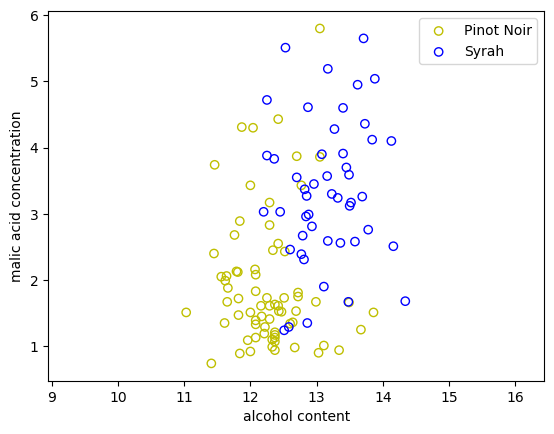

(10.857203737968263, 14.52565698653746, 0.4780714285714287, 6.061928571428572)

In [5]:
color_dict = Dict("Pinot Noir" => "y", "Syrah" => "b")
figure()
xlabel("alcohol content")
ylabel("malic acid concentration")
for df_c in groupby(df, :wine)
    wine = df_c[1, :wine]
    scatter(df_c[:, :alcohol], df_c[:, :malic_acid], label="$wine", marker="o", 
        facecolor="None", edgecolor=color_dict[wine])
end
legend()
axis("equal")

## getting data ready for input to scikitlearn

to build a predictive model in scikitlearn:
* construct a feature matrix `X` that has `n_wines` rows and `2` columns (one column for each feature)
* construct a column vector `y` with the labels

loop through the rows of the wine `DataFrame` and populate each entry of the feature matrix `X` and target vector `y` with appropriate values

In [6]:
n_wines = nrow(df)
X = zeros(n_wines, 2)
y = zeros(n_wines)
for (i, wine) in enumerate(eachrow(df))
    X[i, 1] = wine[:alcohol]
    X[i, 2] = wine[:malic_acid]
    y[i] = wine[:class]
end
X
y

119-element Array{Float64,1}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮  
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

## training a support vector machine (SVM)

train a support vector machine to classify wines using *all* of the data. evaluate the accuracy on the training data. we'll later show through cross-validation that this is an overestimate of the true accuracy of the SVM classifier on unseen data. use `C=1.0`. use the linear kernel. [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) is the documentation for the `SVC` function (Support Vector Classifier) in scikitlearn.

```julia
# use a linear kernel
clf = SVC(kernel="linear", C=1.0)
```

In [7]:
clf = SVC(kernel="linear", C=1.0)
clf.fit(X, y)

PyObject SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

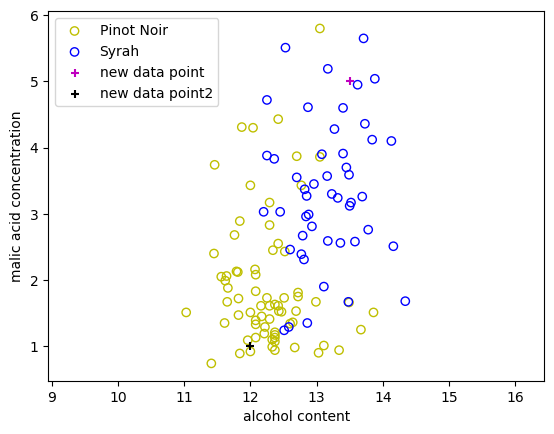

(10.857203737968263, 14.52565698653746, 0.4780714285714287, 6.061928571428572)

In [23]:
x_new=[13.5 5.0]
x_new2=[12.0 1.0]
figure()
xlabel("alcohol content")
ylabel("malic acid concentration")
for df_c in groupby(df, :wine)
    wine = df_c[1, :wine]
    scatter(df_c[:, :alcohol], df_c[:, :malic_acid], label="$wine", marker="o", 
        facecolor="None", edgecolor=color_dict[wine])
end
scatter(x_new[1], x_new[2], marker="+", label="new data point", color="m")
scatter(x_new2[1], x_new2[2], marker="+", label="new data point2", color="k")
legend()
axis("equal")

In [9]:
clf.predict(x_new)

1-element Array{Float64,1}:
 1.0

In [10]:
clf.predict(x_new2)

1-element Array{Float64,1}:
 -1.0

In [11]:
clf.score(X, y)

0.8403361344537815

## visualize the decision boundary

draw the decision boundary (in feature space) learned by the SVM trained on test data. Also plot the data in feature space (with the decision boundary) with different colors/symbols for the different classes (exactly as in `# visualize the data`). hint: follow the class notes for k-nearest neighbors, using `contourf`, but this is not the only way.

In [12]:
alcohol = 7.0:0.25:17.0
malic_acid = 0.0:0.25:10.0
clf_prediction = zeros(length(alcohol), length(malic_acid))

for i=1:length(alcohol)
    for j=1:length(malic_acid)
        x = [alcohol[i] malic_acid[j]]
        clf_prediction[j, i]=clf.predict(x)[1]
    end
end

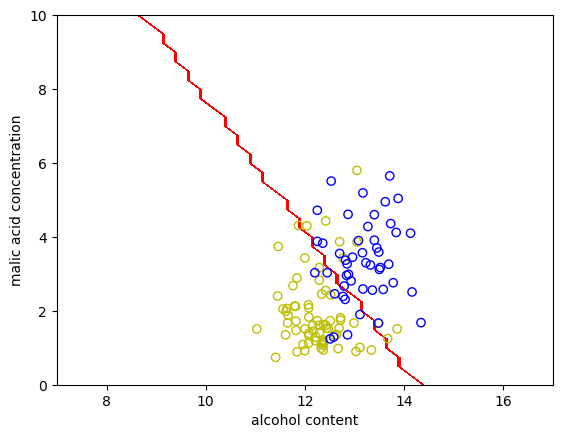

In [13]:
figure()
contourf(alcohol, malic_acid, clf_prediction, 
    [0.0, 0.5, 1.0], colors=["r", "w"])
xlabel("alcohol content")
ylabel("malic acid concentration")
for df_c in groupby(df, :wine)
    wine = df_c[1, :wine]
    scatter(df_c[:, :alcohol], df_c[:, :malic_acid], label="$wine", marker="o", 
        facecolor="None", edgecolor=color_dict[wine])
end

## $K=5$-fold cross validation
use $K=5$-fold cross validation to:
* choose the optimal `C` parameter in the SVM classifier
* assess the accuracy of the model on unseen data

plot the average test set accuracy (average over the $K$ folds) against the `C` parameter used.

report the best `C` parameter and the associated average test set error (`argmax` might be useful). This test set error is a quality metric of how well the SVM will perform on new, unseen data that is not in the training set. explore the following set of `C` parameters: `c_params = 10.0 .^ range(-3, stop=0, length=25)`. 

In [14]:
K = 5 # number of folds
kf = KFold(n_wines, n_folds=K)

c_params = 10.0 .^ range(-3, stop=0, length=25)
test_accuracy = zeros(length(c_params))

for (i, c) in enumerate(eachrow(c_params))
    for (train_ids, test_ids) in kf
        clf = SVC(kernel="linear", C=c)
        clf.fit(X[train_ids, :], y[train_ids])
        test_accuracy[i] += clf.score(X[test_ids, :], y[test_ids])
    end
    test_accuracy[i] /= K
end

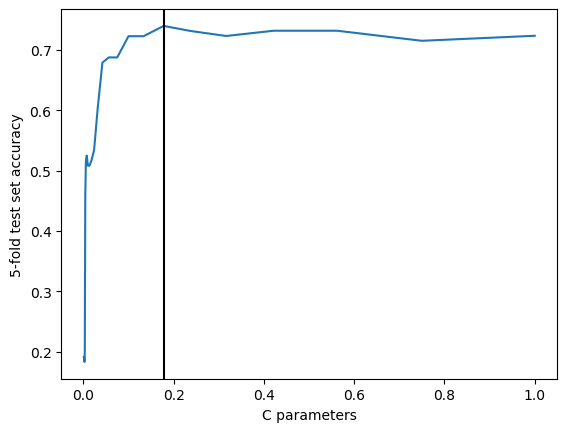

optimal C = 0.1778279410038923
	accuracy: 0.739855072463768


PyObject Text(24.000000000000007, 0.5, '5-fold test set accuracy')

In [16]:
figure()
plot(c_params, test_accuracy)
optimal_c = c_params[argmax(test_accuracy)]
best_accuracy = test_accuracy[argmax(test_accuracy)]
println("optimal C = ", optimal_c)
println("\taccuracy: ", best_accuracy)
axvline(c_params[argmax(test_accuracy)], color="k")
xlabel("C parameters")
ylabel("$K-fold test set accuracy")

my conclusion: We can see that the accuracy calculated on the training data is indeed an overestimate. Through 5-fold cross-validation we see that this is an overestimate of the true accuracy of the SVM classifier. We see that the optimal C parameter is 0.1778279410038923 and an accuracy of 0.739855072463768 which is less than the previously calculated accuracy.